[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/tmp/ipykernel_63721/584832904.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[0].scatter(points[idx, 0], points[idx, 1], label=f"Class {int(label)}", c=[colors[int(label)]], cmap=cmap)
/tmp/ipykernel_63721/584832904.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[1].scatter(points[idx, 0], points[idx, 1], label=f"Class {int(label)}", c=[colors[int(label)]], cmap=cmap)


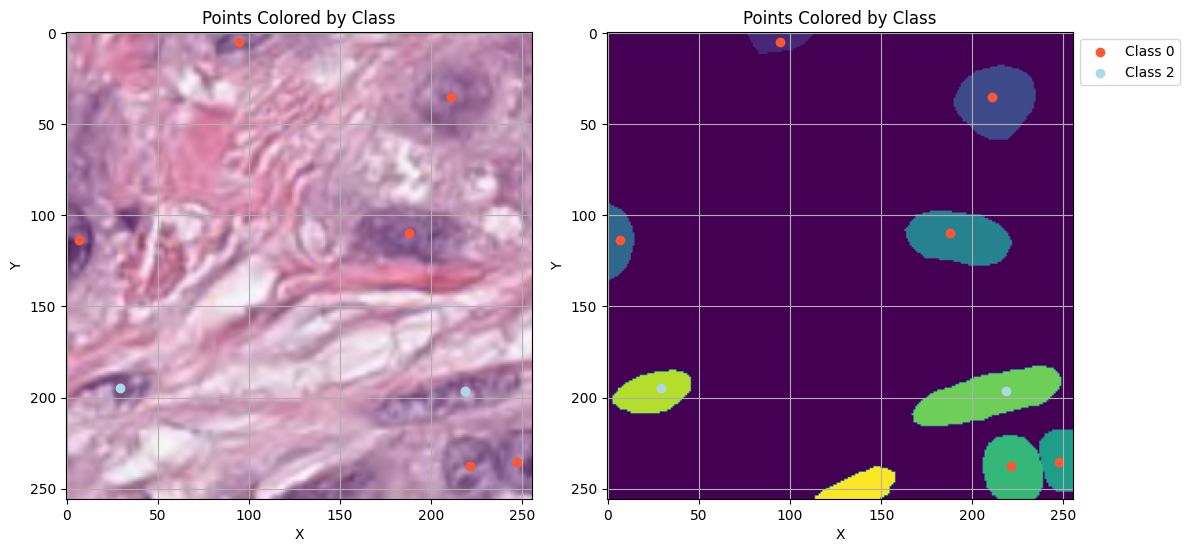

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image

# 生成固定的数字-颜色映射
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
colors = ['#FF5733', '#FFA500', '#ADD8E6', '#800080', '#FFFFFF']

cmap = ListedColormap(colors)

# 读取npy文件
data = np.load("/data/hotaru/my_projects/PromptNucSeg/segmentor/prompts/pannuke123/2_0.npy")
mask_data = np.load("/data/hotaru/my_projects/PromptNucSeg/segmentor/datasets/pannuke/Masks/2_0.npy", allow_pickle=True).item()  # 加载npy文件并将字典转换为Python对象

# 获取mask数据
mask = mask_data['inst_map']
print(mask_data["type_map"])

# 提取坐标和类别信息
points = data[:, :2]
labels = data[:, 2]

# 打开PNG图像
image_path = "/data/hotaru/my_projects/PromptNucSeg/segmentor/datasets/pannuke/Images/2_0.png"
image = Image.open(image_path)


# 创建绘图对象和子图
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 在第一个子图中绘制原始图像和点
axes[0].imshow(image)
for label in np.unique(labels):
    idx = labels == label
    axes[0].scatter(points[idx, 0], points[idx, 1], label=f"Class {int(label)}", c=[colors[int(label)]], cmap=cmap)
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")
axes[0].set_title("Points Colored by Class")
axes[0].grid(True)

# 在第二个子图中绘制mask和点
axes[1].imshow(mask, cmap='viridis')
for label in np.unique(labels):
    idx = labels == label
    axes[1].scatter(points[idx, 0], points[idx, 1], label=f"Class {int(label)}", c=[colors[int(label)]], cmap=cmap)
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")
axes[1].set_title("Points Colored by Class")
axes[1].grid(True)
# 在每个子图的外部显示图例
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
# 调整布局
plt.tight_layout()

# 保存结果图像
plt.savefig("result_combined.png")
plt.show()

# 错误统计

## image-class 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
from scipy.io import loadmat
import cv2

# 生成固定的数字-颜色映射
colors = ['#FF5733',  '#ADD8E6', '#FFD700','#800080', '#FFFFFF',]
colors_mask = ['#FFFFFF', '#FF1F00',  '#4080FF', '#FFFF00','#2D0040', '#999999']
 # 用于绘制 mask 图，颜色保持一致
cmap = ListedColormap(colors)
cmap_mask = ListedColormap(colors_mask)

#return inst_map,type_map,points,points_labels
def load_dataset(dataset,file_name,file_path):
    if dataset == 'pannuke':
        point_data = np.load(file_path+"/"+file_name+".npy")
        mask_data = np.load("./datasets/pannuke/Masks/"+file_name+".npy", allow_pickle=True).item()  # 加载npy文件并将字典转换为Python对象
        inst_map = mask_data['inst_map']
        type_map = mask_data['type_map']
    elif dataset == 'cpm17':
        point_data = np.load("/data/hotaru/my_projects/PNS_tmp/segmentor/prompts/cpm17/"+file_name+".npy")
        mask_data = loadmat("/data/hotaru/my_projects/PNS_tmp/segmentor/datasets/cpm17/test/Labels/"+file_name+".mat")  # 加载npy文件并将字典转换为Python对象
        inst_map = mask_data['inst_map']
        type_map = np.ones_like(inst_map)
    else:
        print("暂不支持其他数据集")
        return
    # 提取坐标和类别信息
    points = point_data[:, :2]
    points_labels = point_data[:, 2]
    return inst_map,type_map,points,points_labels

#return [num_gt_instances,num_points,true_counts,m_back_count,m_front_count,l_single_count,l_multi_count,cls_false_count,all_false_num],temp_inst_map,semantic_liantong_map
def count_false_points(inst_map,type_map,points,points_labels):
    #初始化所需变量
    temp_inst_map = inst_map.copy()
    temp_inst_map = temp_inst_map.astype(np.int8)  # 转换为 CV_8U
    _ , binary_semantic_map = cv2.connectedComponents(temp_inst_map,connectivity=4) 
    binary_semantic_map = binary_semantic_map.astype(np.int8)

    num_gt_instances = 0 # 0. gt总数
    num_points = 0       # 1. points总数
    true_counts = 0      # 2. 正确总数
    m_back_count = 0     # 3. 背景多检
    m_front_count = 0    # 4. 前景多检
    l_single_count = 0   # 5. 单独漏检
    l_multi_count = 0    # 6. 粘连漏检
    cls_false_count = 0  # 7. 类别错误
    all_false_num = 0    # 8. 错误总数


    num_gt_instances = len(np.unique(inst_map)) - 1  # 0. 减去背景标签
    num_points = len(points)                          # 1.
    '''
        开始计算
        * 2. 正确总数：前景非零&非-1&类别正确/没有类别,更新temp_inst_map&semantic_binary_map
        * 4. 前景多检：temp_inst_map = -1
        * 5. 单独漏检：剩余语义图连通图数目
        * 6. 粘连漏检：剩余实例图数目 - 剩余语义图数目
        * 7. 类别错误：前景非零&非-1&类别错误,更新temp_inst_map&semantic_binary_map
    '''
    
    for point , point_label in zip(points,points_labels):
        x,y = int(point[1]),int(point[0])
        label = point_label
        point_is_correct = False # flag
        if temp_inst_map[x, y] != 0 and  temp_inst_map[x, y] != -1 and label == type_map[x,y]-1 :  # 2.
            true_counts += 1
            point_is_correct = True        
            # 删掉已经定位的inst
            liantong_num, liantong_map = cv2.connectedComponents(binary_semantic_map,connectivity=4) 
            temp_inst_id = temp_inst_map[x, y]  
            temp_liantong_id = liantong_map[x,y]
            for i in range(temp_inst_map.shape[0]):  
                for j in range(temp_inst_map.shape[1]):  
                    if temp_inst_map[i, j] == temp_inst_id:  
                        temp_inst_map[i, j] = -1  
                    if liantong_map[i,j] == temp_liantong_id:
                        binary_semantic_map[i, j] = 0

        if point_is_correct == False and inst_map[x, y] == 0:   #3.
            m_back_count += 1
        
        if point_is_correct == False and temp_inst_map[x, y] == -1 :   #4.
            m_front_count += 1
        if point_is_correct == False and temp_inst_map[x, y] != 0 and  temp_inst_map[x, y] != -1 and label != type_map[x,y]-1:
            cls_false_count += 1
            # 删掉已经定位的inst
            liantong_num, liantong_map = cv2.connectedComponents(binary_semantic_map,connectivity=4) 
            temp_inst_id = temp_inst_map[x, y]  
            temp_liantong_id = liantong_map[x,y]
            for i in range(temp_inst_map.shape[0]):  
                for j in range(temp_inst_map.shape[1]):  
                    if temp_inst_map[i, j] == temp_inst_id:  
                        temp_inst_map[i, j] = -1  
                    if liantong_map[i,j] == temp_liantong_id:
                        binary_semantic_map[i, j] = 0

    semantic_liantong_num, semantic_liantong_map = cv2.connectedComponents(binary_semantic_map) 
    l_single_count = semantic_liantong_num -1   # 5
    l_multi_count = num_gt_instances - true_counts - cls_false_count - l_single_count  # 6
    if l_multi_count < 0 : l_multi_count = 0

    all_false_num = m_back_count + m_front_count + l_single_count + l_multi_count + cls_false_count
    # print("0. gt总数",num_gt_instances)
    # print("1. points总数",num_points)
    # print("2. 正确总数",true_counts)
    # print("3. 背景多检",m_back_count)
    # print("4. 前景多检",m_front_count)
    # print("5. 单独漏检",l_single_count)
    # print("6. 粘连漏检",l_multi_count)
    # print("7. 类别错误",cls_false_count)
    # print("8. 错误总数",all_false_num)

    return [num_gt_instances,num_points,true_counts,m_back_count,m_front_count,l_single_count,l_multi_count,cls_false_count,all_false_num],temp_inst_map,semantic_liantong_map

In [9]:
import os
import csv

dataset = 'pannuke'
# 指定文件夹路径
folder_path = "/data/hotaru/projects/PNS_tmp/segmentor/prompts/pannuke321"
# 获取文件夹中的文件名列表
file_names = os.listdir(folder_path)
csv_file = "/data/hotaru/projects/PNS_tmp/segmentor/pannuke321_che_count.csv"
# 字段名列表，根据你的需求自行修改
field_names = ["file_name", "num_gt_instances", "num_points", "true_counts", "m_back_count", "m_front_count", "l_single_count", "l_multi_count", "cls_false_count", "all_false_num"]

count = 0
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(field_names)
    for file_name in file_names:
        file_name = file_name.split('.')[0]
        inst_map,type_map,points,points_labels = load_dataset(dataset, file_name)
        false_points,temp_inst_map, semantic_liantong_map= count_false_points(inst_map,type_map,points,points_labels)
        row = [file_name] + false_points
        writer.writerow(row)
        count+=1
        print(count , row)




1 ['1_0', 8, 11, 6, 4, 0, 1, 0, 1, 6]
2 ['1_1', 10, 13, 7, 5, 0, 1, 1, 1, 8]
3 ['1_10', 18, 17, 14, 1, 1, 2, 1, 1, 6]
4 ['1_100', 21, 22, 12, 1, 0, 0, 0, 9, 10]
5 ['1_1000', 2, 3, 2, 0, 1, 0, 0, 0, 1]
6 ['1_1001', 7, 7, 4, 3, 0, 3, 0, 0, 6]
7 ['1_1002', 5, 6, 5, 1, 0, 0, 0, 0, 1]
8 ['1_1003', 6, 9, 5, 4, 0, 1, 0, 0, 5]
9 ['1_1004', 5, 7, 4, 3, 0, 1, 0, 0, 4]
10 ['1_1005', 5, 3, 3, 0, 0, 2, 0, 0, 2]
11 ['1_1006', 7, 4, 4, 0, 0, 3, 0, 0, 3]
12 ['1_1007', 5, 3, 2, 1, 0, 2, 1, 0, 4]
13 ['1_1008', 17, 16, 9, 2, 0, 3, 0, 5, 10]
14 ['1_1009', 12, 12, 3, 2, 0, 2, 0, 7, 11]
15 ['1_101', 25, 30, 14, 6, 0, 1, 0, 10, 17]
16 ['1_1010', 15, 15, 9, 2, 0, 2, 0, 4, 8]
17 ['1_1011', 6, 5, 5, 0, 0, 1, 0, 0, 1]
18 ['1_1012', 10, 13, 8, 3, 1, 1, 0, 1, 6]
19 ['1_1013', 1, 0, 0, 0, 0, 1, 0, 0, 1]
20 ['1_1014', 12, 9, 7, 1, 1, 4, 1, 0, 7]
21 ['1_1015', 2, 2, 1, 0, 0, 0, 0, 1, 1]
22 ['1_1016', 8, 5, 3, 0, 0, 3, 0, 2, 5]
23 ['1_1017', 10, 8, 6, 1, 0, 2, 1, 1, 5]
24 ['1_1018', 47, 64, 30, 21, 0, 3, 1, 13, 38]
25

In [4]:
import csv
import pandas as pd
# 0. gt总数
# 1. points总数
# 2. 正确总数
# 3. 背景多检
# 4. 前景多检
# 5. 单独漏检
# 6. 粘连漏检
# 7. 类别错误
# 8. 错误总数

# 打开CSV文件
csv_file = "/data/hotaru/projects/PNS_tmp/segmentor/pannuke321_che_count.csv"
# 使用pandas读取CSV文件
df = pd.read_csv(csv_file)

# 计算除第一列之外的其他列的和
data = df.sum(axis=0)[1:]  # axis=0表示按列求和，[1:]表示从第二列开始求和，因为第一列是文件名


# 打印结果
print("每行除第一列之外的和:", data)
print("正确总数：",data[2])
print("准确率：",data[2]/data[1])
print("召回率：",data[2]/data[0])
print("背景多检：",data[3])
print("前景多检：",data[4])
print("单独漏检：",data[5])
print("粘连漏检：",data[6])
print("类别错误：",data[7])
print("错误总数：",data[8])

每行除第一列之外的和: num_gt_instances    123090
num_points          127578
true_counts          93146
m_back_count         17492
m_front_count         1931
l_single_count        9669
l_multi_count         5268
cls_false_count      15007
all_false_num        49367
dtype: object
正确总数： 93146
准确率： 0.7301102070889965
召回率： 0.7567308473474693
背景多检： 17492
前景多检： 1931
单独漏检： 9669
粘连漏检： 5268
类别错误： 15007
错误总数： 49367


/tmp/ipykernel_22909/118292906.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("正确总数：",data[2])
/tmp/ipykernel_22909/118292906.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("准确率：",data[2]/data[1])
/tmp/ipykernel_22909/118292906.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("召回率：",data[2]/data[0])
/tmp/ipykernel_22909/118292906.py:27: FutureWarning: Series.__getitem__ treating keys as positions is

## 单独图像绘图示例

/tmp/ipykernel_104236/3009463384.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[0].scatter(points[idx, 0], points[idx, 1], label=f"Class {int(label)}", c=[colors[int(label)]], cmap=cmap)
/tmp/ipykernel_104236/3009463384.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[1].scatter(points[idx, 0], points[idx, 1], label=f"Class {int(label)}", c=[colors[int(label)]], cmap=cmap)


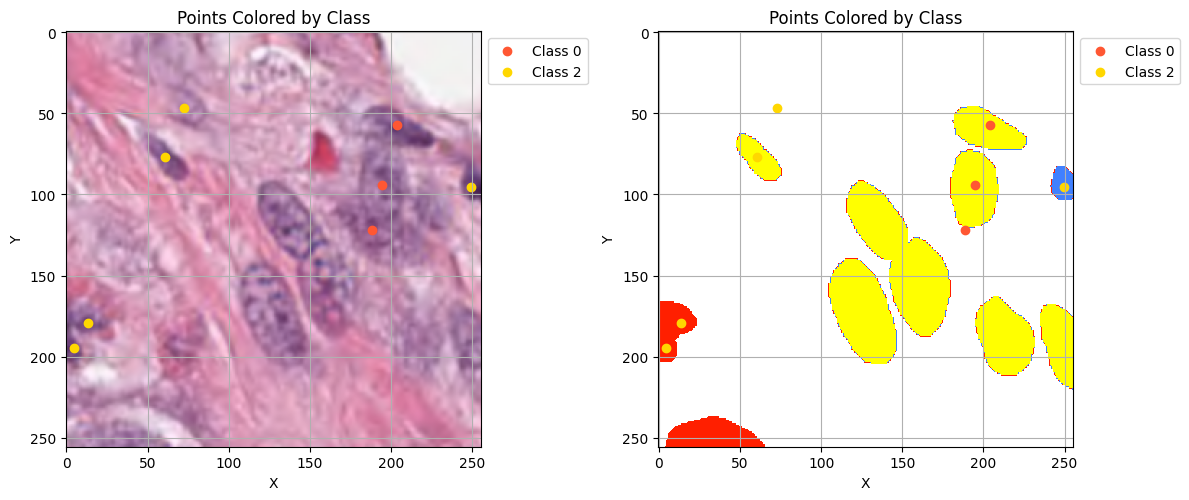

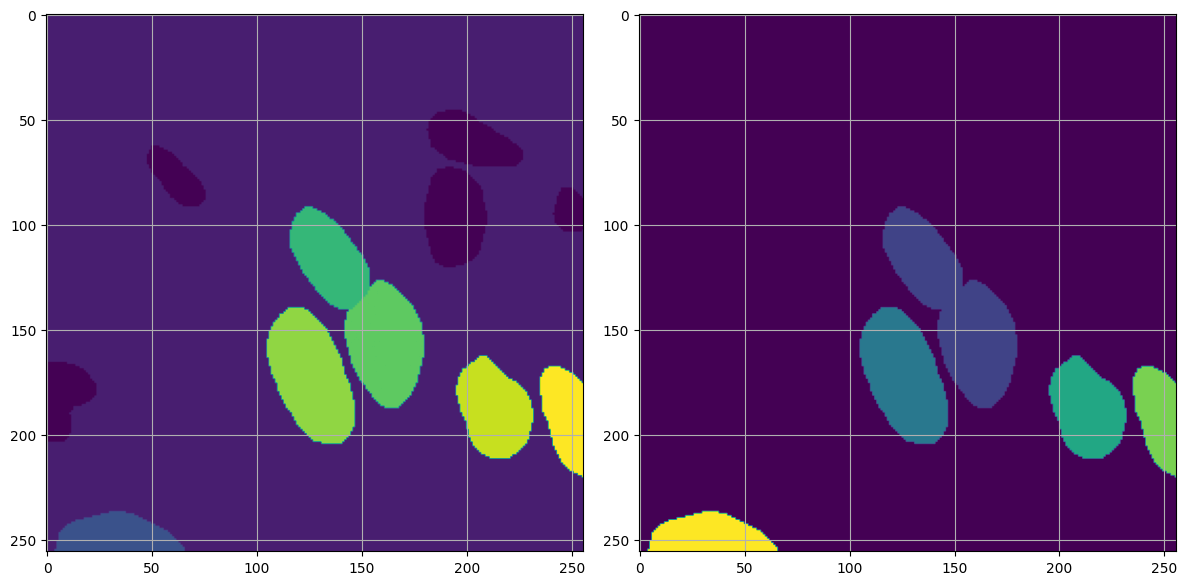

In [3]:
dataset = 'pannuke'
file_name = '1_8'
file_path = '/data/hotaru/projects/PNS_tmp/segmentor/prompts/pannuke321_chpo_121'
inst_map,type_map,points,points_labels = load_dataset(dataset, file_name,file_path)
false_points,temp_inst_map, semantic_liantong_map= count_false_points(inst_map,type_map,points,points_labels)

# 打开PNG图像
image_path = "./datasets/pannuke/Images/"+file_name+".png"
image = Image.open(image_path)
# 创建绘图对象和子图
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
for label in np.unique(points_labels):
    idx = points_labels == label
    axes[0].scatter(points[idx, 0], points[idx, 1], label=f"Class {int(label)}", c=[colors[int(label)]], cmap=cmap)
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")
axes[0].set_title("Points Colored by Class")
axes[0].grid(True)

# 在第二个子图中绘制mask和点
axes[1].imshow(type_map, cmap=cmap_mask, vmin=0, vmax=len(colors_mask)-1)
for label in np.unique(points_labels):
    idx = points_labels == label
    axes[1].scatter(points[idx, 0], points[idx, 1], label=f"Class {int(label)}", c=[colors[int(label)]], cmap=cmap)
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")
axes[1].set_title("Points Colored by Class")
axes[1].grid(True)

# 在每个子图的外部显示图例
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(temp_inst_map)
axes[0].grid(True)

axes[1].imshow(semantic_liantong_map )
axes[1].grid(True)
plt.tight_layout()
plt.show()
